# Paper reproduction of tables and figures

## package dependencies

In [147]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
from tqdm import tqdm
import networkit as nk

from model import DrBC
from utils import Metrics
from generator import TrainGraph
from sklearn.decomposition import PCA

plt.style.use('ggplot')

## reproduction
There are 2 figures and 11 tables for reproduction

### figure 3.

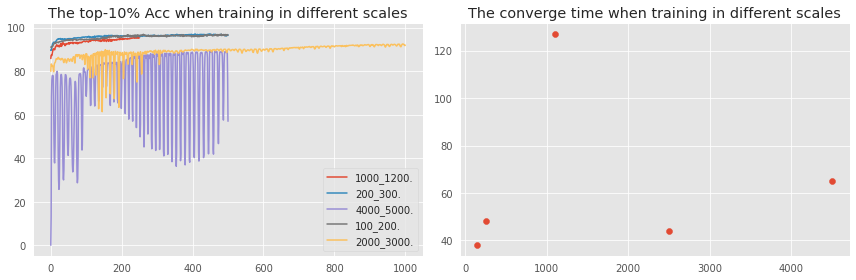

In [162]:
log_files = [ os.path.join('logs', file) for file in os.listdir('logs') ]
fig, ax = plt.subplots(1,2,figsize=(12, 4))
time_x = [1100, 250,4500, 150,   2500]
time_y = []

for log_file in log_files:
    with open(log_file, "rb") as f:
        logs = pickle.load(f)
        time_y.append(int(logs['time'][1]-logs['time'][0]))
        ax[0].set_title("The top-10% Acc when training in different scales")
        ax[0].plot(range(len(logs['eval_acc'])), [acc/100 for acc in logs['eval_acc']], label=log_file.split('/')[-1][:-3])
        ax[0].legend()
        
ax[1].set_title("The converge time when training in different scales")
ax[1].scatter(time_x, time_y)
fig.set_tight_layout(True)
fig.savefig('reproduce/figure3.png')
plt.show()

### figure 4.

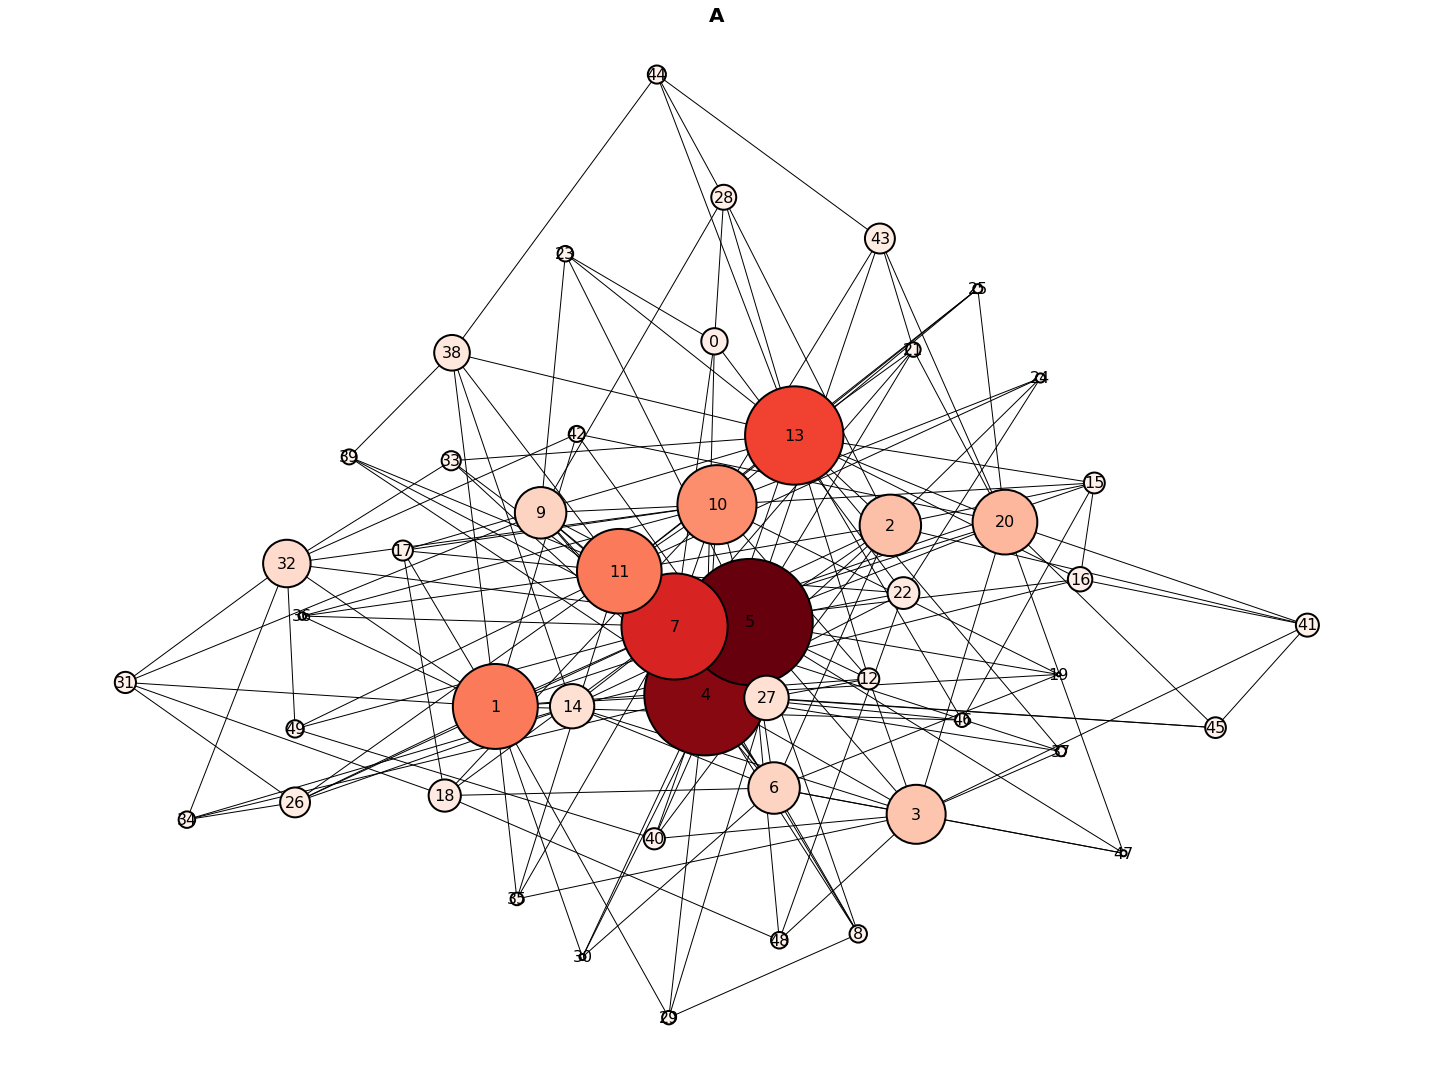

In [137]:
graph = nx.powerlaw_cluster_graph(n=50, m=4, p=0.05)
bc = list(nx.betweenness_centrality(graph).values())
max_bc, min_bc = max(bc), min(bc)
bc_cmap = [(v-min_bc)/(max_bc-min_bc) for v in bc]

fig, ax = plt.subplots(figsize=(20, 15))
nx.draw_networkx(
    graph,
    with_labels=True,
    node_size=[v*100000 for v in bc],
    node_color=bc_cmap,
    cmap=plt.cm.Reds,
    font_size=16,
    font_color="black",
    edgecolors="black",
    linewidths=2
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("A", font)
# Change font color for legend
font["color"] = "r"

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
fig.savefig('reproduce/figure4_graph.png')
plt.axis("off")
plt.show()

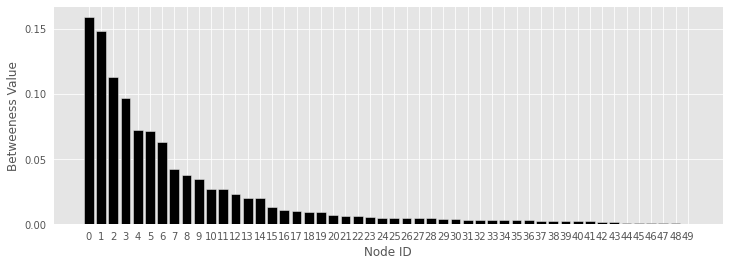

In [138]:
y_ticks = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
x_ticks = range(len(bc))
plt.figure(figsize=(12, 4))
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.bar(x_ticks, sorted(bc, reverse=True), color="black")
plt.ylabel("Betweeness Value")
plt.xlabel("Node ID")
plt.savefig('reproduce/figure4_bcvalue.png')
plt.show()

#### Enbedding PCA plotting

In [143]:
model = DrBC()
model.load_state_dict(torch.load('model_result/1000_1200.pth'))

<All keys matched successfully>

In [145]:
edge_idx = [[], []]
degrees = []
for begin_node, end_node in graph.edges:
    # undirected
    edge_idx[0].append(begin_node)
    edge_idx[1].append(end_node)
    edge_idx[0].append(end_node)
    edge_idx[1].append(begin_node)

degrees.extend(
    [value for _, value in nx.degree(graph)]
)
result = model.encoder(
    torch.tensor([[degree, 1, 1] for degree in degrees], dtype=torch.float),
    torch.tensor(edge_idx, dtype=torch.long)
)

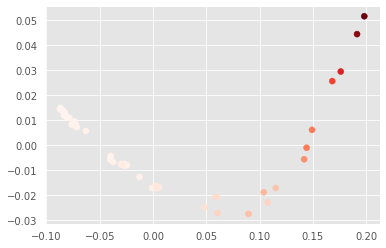

In [161]:
pca2 = PCA(n_components=2)
result_pca = pca2.fit_transform(result.detach().numpy())
plt.scatter(result_pca[:, 0], result_pca[:, 1],cmap=plt.cm.Reds, c=bc_cmap)
plt.savefig('reproduce/figure4_pca.png')
plt.show()

## Generating all testing data

In [133]:
scales = ['5000', '10000', '20000', '50000', '100000']
N = 10
for _, scale in enumerate(tqdm(scales)):
    for i in tqdm(range(N)):
        data = TrainGraph(batch_size=1, scale=(int(scale), int(scale)+1))
        data.save(f"test_30/{scale}_{i}.pkl")

  0%|          | 0/3 [15:25<?, ?it/s]


KeyboardInterrupt: 

### Table 6. and Table 7.
* run **30 times** for each scale
* find the **mean** and **std** to draw a table

In [94]:
train_scales = ["100_200", "200_300", "1000_1200", "2000_3000", "4000_5000"]
test_scales = [5000, 10000, 20000, 50000, 100000]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

result = [[ [[], []] for j in range(len(test_scales))] for i in range(len(train_scales))]

for i, train_scale in train_scales:
    # load the model
    model = DrBC()
    model.load_state_dict(torch.load(os.path.join('model_result', f'{train_scale}.pth')))
    model.to(device)
    for j, test_scale in enumerate(test_scales):
        for k in range(N):
            # load data
            data = TrainGraph(batch_size=1, scale=None, path=os.path.join('test_30', f'{test_scale}_{k}.pkl'))
            metrics = Metrics()

            model.eval()
            # preparing the data
            graph_input = data.get_input()
            edge_idx = data.get_edge_idx()
            gt = data.get_ground_truth()

            # converting the data into torch tensor and certain device
            graph_input = torch.tensor(graph_input, dtype=torch.float)
            edge_idx = torch.tensor(edge_idx, dtype=torch.long)
            gt = torch.tensor(gt).view(-1, 1)

            with torch.no_grad():
                pred = model(graph_input.to(device), edge_idx.to(device))
                metrics.set_output(pred, gt)

            result[i][j][0].append(metrics.top_k(k=1))
            result[i][j][1].append(metrics.kendall_tau())

print("======================= TOP-1% =======================")
for i, train_scale in enumerate(train_scales):
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][0])
        std = np.std(result[i][j][0])
        print(f"\t{train_scale}: ", ending="")
        print(f"{avg}\u00B1{std}")
print("======================= Kendall =======================")
for i, train_scale in enumerate(train_scales):
    for j, test_scale in enumerate(test_scales):
        avg = np.mean(result[i][j][1])
        std = np.std(result[i][j][1])
        print(f"\t{train_scale}: ", ending="")
        print(f"{avg}\u00B1{std}")

  0%|          | 0/30 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def kadabra(graph, bc, metrics):
    graph = nk.nxadapter.nx2nk(graph)
    alg = nk.centrality.KadabraBetweenness(graph)
    metrics.start_timer()
    alg.run()
    metrics.end_timer()
    metrics.set_output(np.array(alg.scores), bc)
    return {
     "time": metrics.get_runtime(), "1Acc": metrics.top_k(k=1), "5Acc": metrics.top_k(k=5),
     "10Acc": metrics.top_k(k=10), "Kendall": metrics.kendall_tau()
    }
def RK(graph, bc, metrics):
    graph = nk.nxadapter.nx2nk(graph)
    alg = nk.centrality.ApproxBetweenness(graph)
    metrics.start_timer()
    alg.run()
    metrics.end_timer()
    metrics.set_output(np.array(alg.scores), bc)
    return {
     "time": metrics.get_runtime(), "1Acc": metrics.top_k(k=1), "5Acc": metrics.top_k(k=5),
     "10Acc": metrics.top_k(k=10), "Kendall": metrics.kendall_tau()
    } 